## Project description: Bank customer churn prediction

Customers are the foundation of any business, including banking. The bank aims to reduce churn because retaining existing customers is usually cheaper than acquiring new ones.

In this project, we build a model that predicts whether a customer will leave the bank in the near future, using historical data on customer behaviour and contract terminations.

We aim to achieve the highest possible **F1 score**, with a minimum target of **0.59**. In addition, we will compute **ROC AUC** and compare it with the F1 score.

**Goal: build a model with the highest possible F1 score (≥ 0.59).**

### Plan

Step 1. Initial data review.

Step 2. Data preprocessing.

Step 3. Class balance analysis.

Step 4. Train baseline models without addressing class imbalance. Conclusions.

Step 5. Improve model quality by addressing class imbalance (try multiple approaches/models). Conclusions.

Step 6. Final testing.

In [1]:
import pandas as pd #loading the necessary libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

## Initial data review

In [2]:
df = pd.read_csv('Churn.csv') #/datasets/Churn.csv 
display(df.head(10))
df.info()
print(f'Share of positive cases :{round(df.Exited.mean()*100)}% \n')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
Share of positive cases :20% 



We have a dataset with 14 columns and 10,000 observations (rows).

**Features**
- `RowNumber` — row index
- `CustomerId` — unique customer identifier
- `Surname` — surname
- `CreditScore` — credit score
- `Geography` — country of residence
- `Gender` — gender
- `Age` — age
- `Tenure` — number of years the customer has been with the bank
- `Balance` — account balance
- `NumOfProducts` — number of bank products used by the customer
- `HasCrCard` — has a credit card
- `IsActiveMember` — customer activity indicator
- `EstimatedSalary` — estimated salary

**Target**
- `Exited` — whether the customer left the bank

The data types match the description of the variables.

The target is binary. The share of positive cases is around 20%, which indicates a clear class imbalance.

Missing values are present only in the `Tenure` column.

The dataset contains both categorical and numerical features.

## Data preprocessing


We convert column names to snake_case: lower case with underscores.

In [3]:
for name in df.columns:
    df.rename(columns = {name: '_'.join(re.findall('[A-Z][^A-Z]*', name)).lower()}, inplace=True)
df.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


We check the dataset for duplicates using the customer identifier.


In [4]:
df.duplicated('customer_id').sum()

np.int64(0)

We remove columns that are not required for modelling:
- `row_number` — duplicates the DataFrame index and does not add information;
- `customer_id` and `surname` — personal identifiers that are not needed for prediction.

In [5]:
df = df.drop(['row_number', 'customer_id', 'surname'], axis = 1)
df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


To understand the overall “shape” of the data, we start with a visual exploration of the key features. We plot feature distributions (by churn status) and pairwise relationships between numerical variables. Based on these plots, we record **preliminary visual observations** — early impressions that may indicate patterns in the data, but must be validated with summary statistics and model results later.


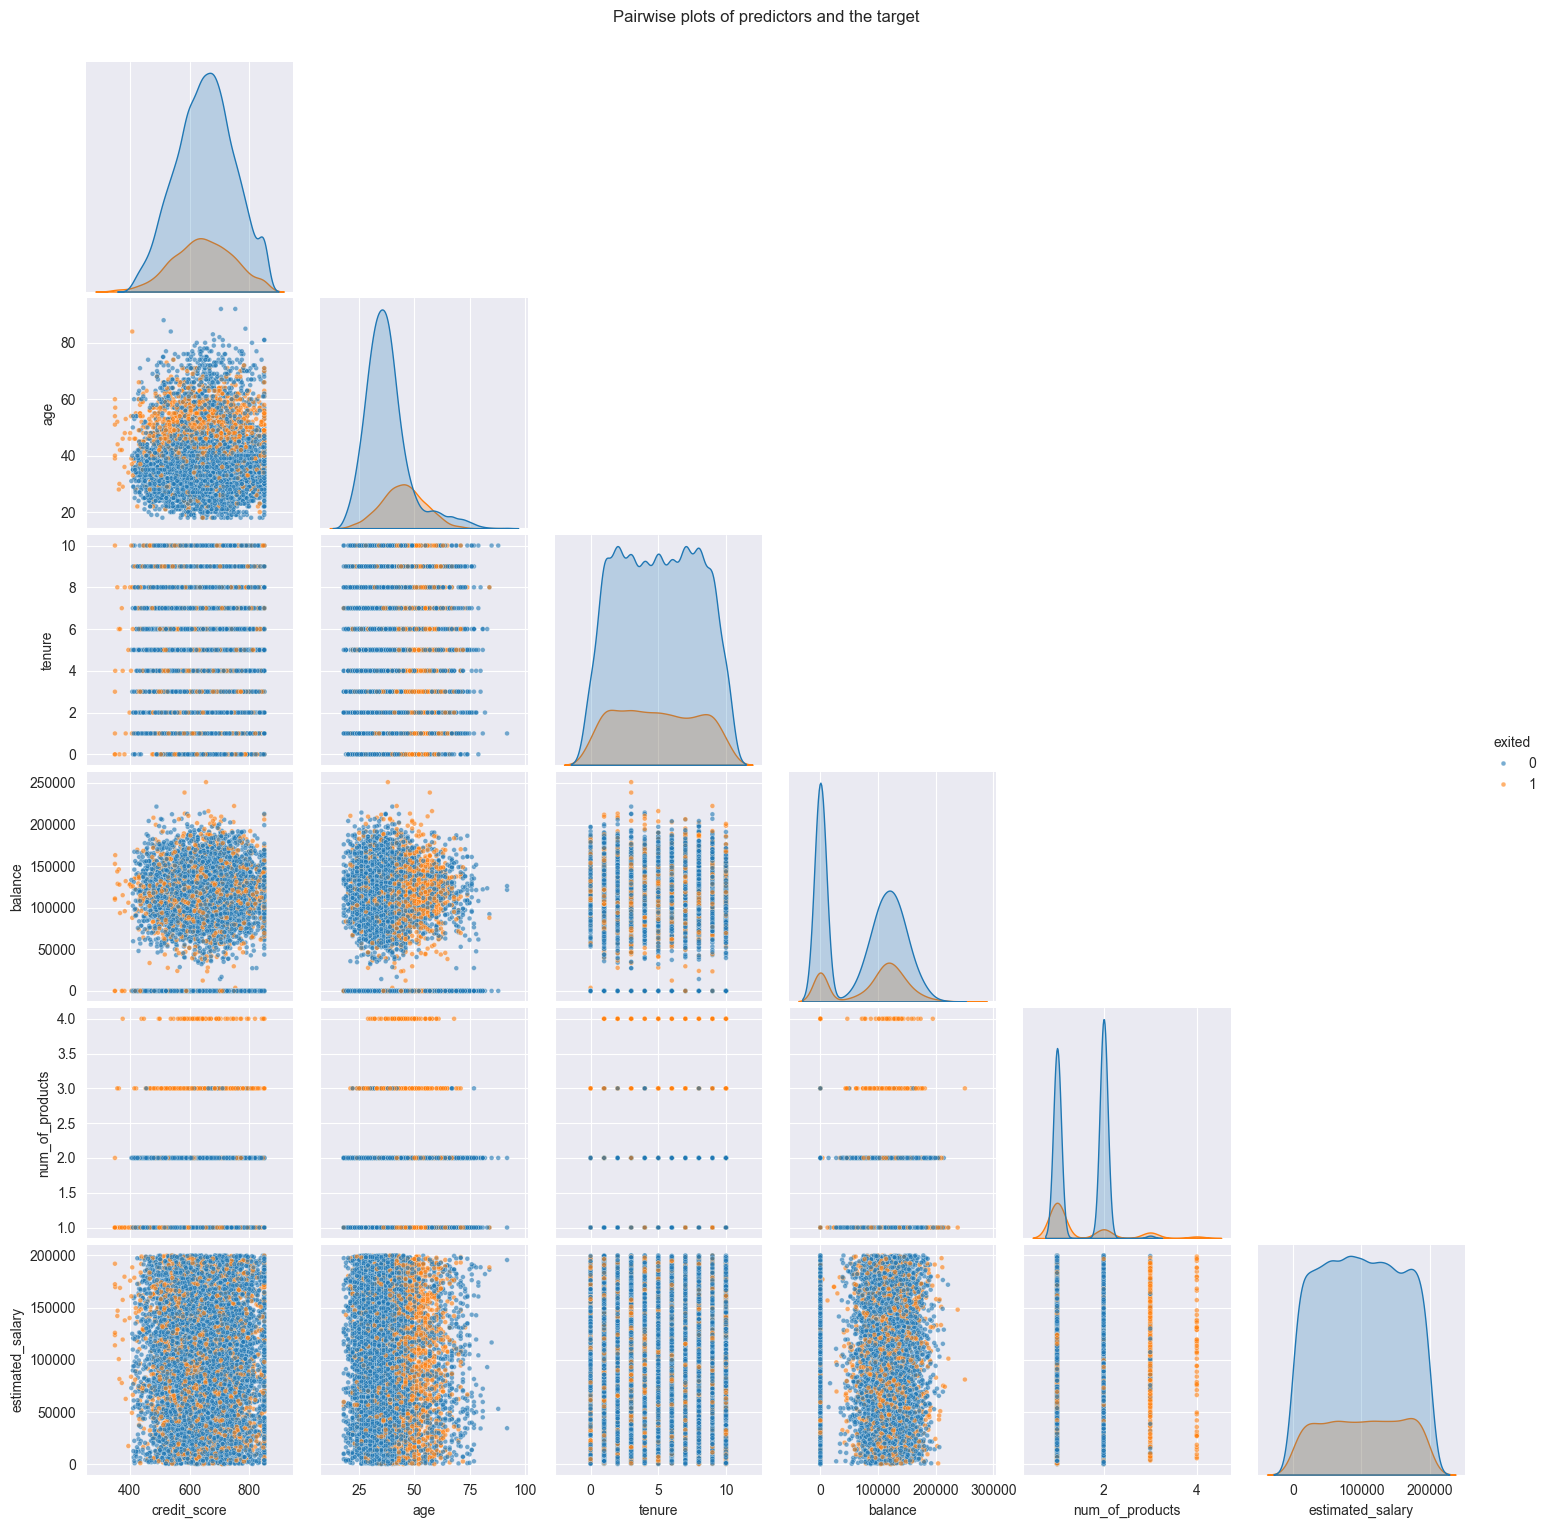

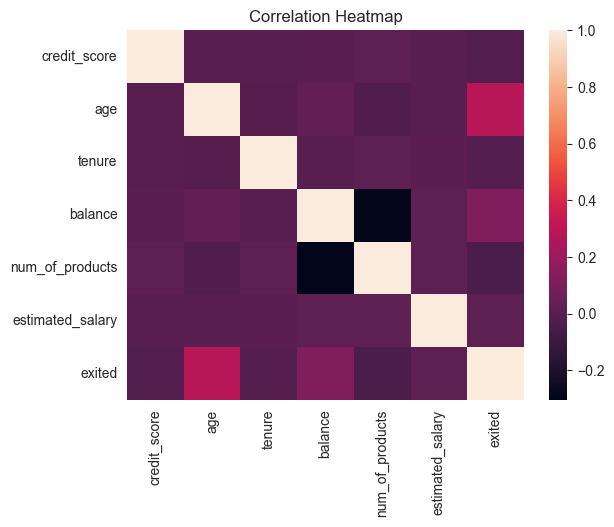

In [6]:
columns = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary', 'exited']
sns.pairplot(df[columns], hue = 'exited',corner=True, diag_kind='kde',plot_kws={'alpha': 0.6, 's':12})
plt.suptitle("Pairwise plots of predictors and the target", y =1.02) # y= some height>1
plt.show()
sns.heatmap(df[columns].corr())
plt.title('Correlation Heatmap')
plt.show()

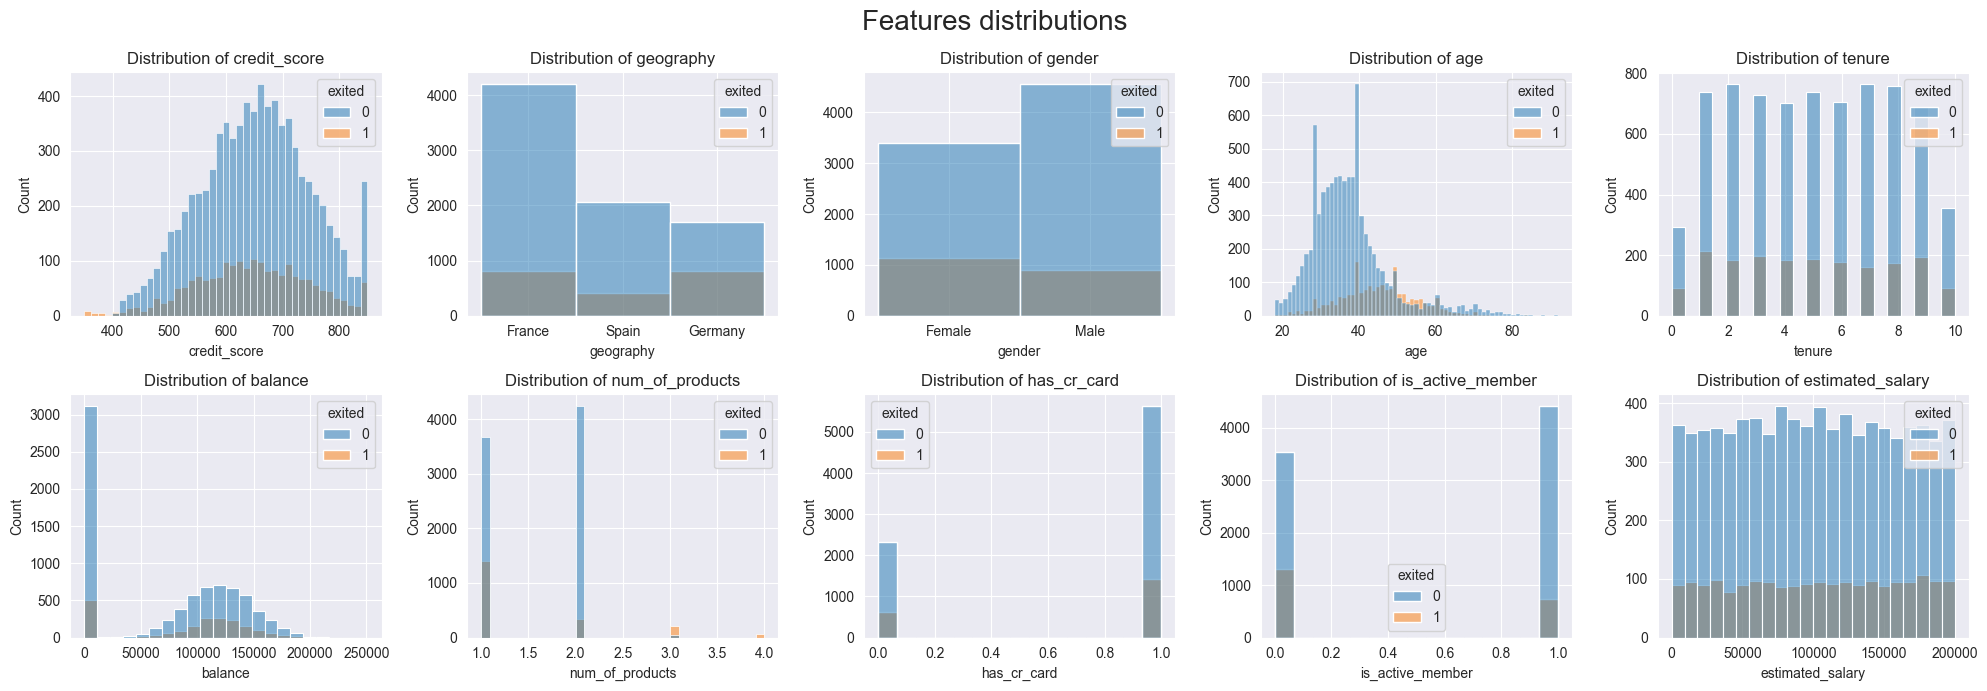

In [7]:
features_name = df.columns
fig, ax = plt.subplots(2,5, figsize = (20,7))
fig.suptitle('Features distributions', fontsize = 20)
for i in range(2):
    for j in range(5):
        ax[i,j] = sns.histplot(data = df, x = features_name[j+i*5], ax = ax[i,j], hue = 'exited')
        ax[i,j].set_title(f'Distribution of {features_name[j+i*5]}')
plt.tight_layout()

### Preliminary visual observations (EDA) — to be validated

These are early, visual impressions from the plots. They are not final conclusions. For each observation, we note a possible alternative explanation and how we will check it.

- **Age (roughly 40–60):** churn appears more common among middle-aged customers.
  - *Alternative explanation:* this could be driven by the age distribution of the dataset (there may simply be more customers in this age range), or by confounding factors correlated with age.
  - *Check:* compute churn rate by age bins (percentage of `exited = 1` within each age group), and compare group sizes.

- **Number of products (>2):** customers using more than two products appear more likely to leave.
  - *Alternative explanation:* this group might be small, and the pattern could be unstable; it may also reflect a specific customer segment rather than a causal effect of product count.
  - *Check:* calculate churn rate and sample size for each `num_of_products` category.

- **Credit score (below ~400):** churn appears higher at lower credit scores, with a noticeable increase below ~400 (visual estimate).
  - *Alternative explanation:* this may be due to a small number of observations in the low-score tail, or noise in the distribution.
  - *Check:* compute churn rate by credit score bins (e.g., quantiles or fixed ranges) and inspect counts per bin.

- **Multicollinearity:** the pair plots and the correlation matrix do not suggest strong multicollinearity among the numerical features.
  - *Alternative explanation:* non-linear relationships may still exist, and correlation captures only linear dependence.
  - *Check:* confirm with correlation values and proceed with baseline modelling; if needed, use regularised models to reduce sensitivity to correlated features.

The distributions of `estimated_salary` and `tenure` look unusual.
`tenure` appears close to uniformly distributed across integer values, and `estimated_salary` shows a near-uniform spread. This raises the possibility that the dataset (or these particular features) may have been generated or heavily preprocessed (e.g., rounded, capped, or simulated).
We will keep these features for modelling, but interpret them with caution.

### Handling missing values in `tenure`

The `tenure` feature contains missing values, so we inspect the share of missing data and the distribution of observed values.

We will consider several strategies for handling missing `tenure` and choose the option that leads to the best model performance.

Missing values in `tenure`: 9.09%


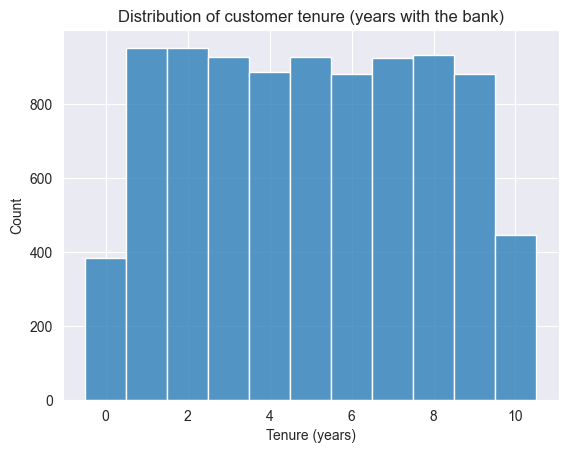

In [8]:
missing_pct = df['tenure'].isna().mean() * 100
print(f'Missing values in `tenure`: {missing_pct:.2f}%')
sns.histplot(df['tenure'], bins=11, discrete=True)
plt.title('Distribution of customer tenure (years with the bank)')
plt.xlabel('Tenure (years)')
plt.ylabel('Count')
plt.show()

We will consider the following options:

- impute missing values with the minimum value (0);
- impute missing values with the median;
- drop rows with missing `tenure`;
- drop the `tenure` feature.


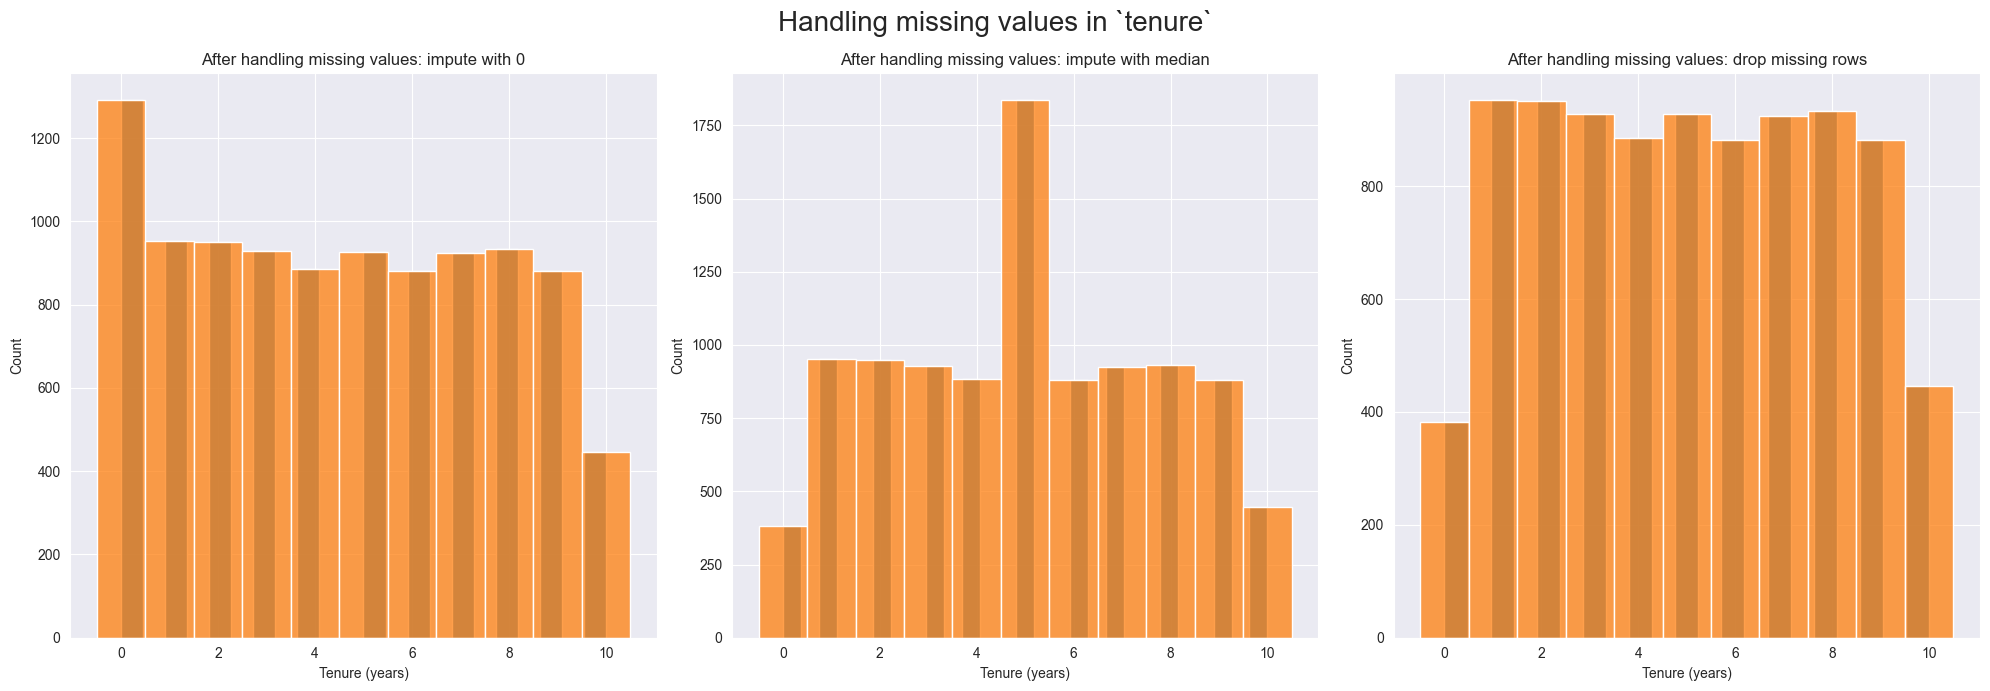

In [9]:
df_zero = df.copy() # Option 1: impute missing `tenure` with 0
df_zero['tenure'] = df_zero['tenure'].fillna(0)

df_median = df.copy() # Option 2: impute missing `tenure` with the median
df_median['tenure'] = df_median.tenure.fillna(df_median.tenure.median())

df_dropna = df.copy().dropna(axis=0)# Option 3: drop rows with missing `tenure`

df_drop = df.copy().drop(['tenure'], axis=1)# Option 4: drop the `tenure` feature

df_list = [df_zero, df_median, df_dropna] # The 4th option has no `tenure`, no need for a plot
list_name = ['impute with 0', 'impute with median', 'drop missing rows']

fig, ax = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('Handling missing values in `tenure`', fontsize=20)

for i in range(len(df_list)):
    ax[i] = sns.histplot(df_list[i].tenure, ax = ax[i])
    sns.histplot(data=df_list[i], x='tenure', bins=11, discrete=True, ax=ax[i])
    ax[i].set_title(f'After handling missing values: {list_name[i]}')
    ax[i].set_xlabel('Tenure (years)')
    ax[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

### Choosing a strategy for `tenure`

We compared several ways of handling missing values in `tenure` and selected the approach based on model performance.

- Imputing missing `tenure` with 0 or with the median introduces artificial values (additional peaks) and may add noise to the feature.
- Dropping rows with missing `tenure` reduces the training data by about 9%, which may lead to a loss of information.

In our experiments, the best model performance was achieved when `tenure` was removed. Therefore, we choose option 4 and **drop the `tenure` column**, using `df_drop` for the rest of the analysis.



## Data preparation

We create a modelling dataset using one-hot encoding with protection against the dummy variable trap (`drop_first=True`).

Next, we split the data into the target variable (`target`) and the feature matrix (`features`).

We then split the dataset into three parts:
- `features_train`, `target_train` — training set (60%)
- `features_valid`, `target_valid` — validation set (20%)
- `features_test`, `target_test` — test set (20%)

We use stratified splitting (`stratify=target`) to preserve the original class proportions in each subset.

In [10]:
df_drop = pd.get_dummies(df_drop, drop_first = True) # ohe-coding
features = df_drop.drop('exited', axis = 1)
target = df_drop['exited']
features_train_valid, features_test, target_train_valid, target_test = train_test_split(features, target, test_size = .2, 
                                                                                        random_state = 12345, stratify = target) 
features_train, features_valid, target_train, target_valid = train_test_split(features_train_valid, target_train_valid, test_size = .25,
                                                                              random_state = 12345, stratify = target_train_valid) 
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(6000, 10) (6000,)
(2000, 10) (2000,)
(2000, 10) (2000,)


## Checking class balance


We examine the class distribution in the target variable. Since we used stratified splitting (`stratify`), the class proportions in the train/validation/test subsets should remain close to the original distribution.

In [11]:
df['exited'].value_counts(normalize = True)

exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


The classes are imbalanced (approximately 1:4). We start by training baseline models **without** any class-balancing techniques, and then address class imbalance in the next steps.

## Training baseline models without handling class imbalance

We start by training several baseline classifiers **without** applying any class-balancing techniques. This provides a reference point for comparison.

Models used:
- Logistic Regression
- Random Forest
- Decision Tree

In [12]:
def metrics(name, model, X, y):
    """function that summarize all scores of the model in the dictionary.
    Input parameters: name of the model, model and features_valid that equal to features_valid by default
    and equal to features_valid_scaled for Logistic Regression"""
    predicted = model.predict(X)
    accuracy = accuracy_score(y, predicted)
    recall = recall_score(y, predicted)
    precision = precision_score(y, predicted)
    f1 = f1_score(y, predicted)
    probabilities = model.predict_proba(X)[:, 1]
    roc_auc = roc_auc_score(y, probabilities)
    print('Model parameters:')
    pprint(model.get_params())
    dict_scores = {name:[accuracy, recall, precision, f1, roc_auc]}
    scores = pd.DataFrame(dict_scores).T
    scores.columns = ['accuracy', 'recall', 'precision', 'f1_score', 'roc_auc']
    display(scores)
    return dict_scores

### Decision Tree Classifier

Since later in the project (when addressing class imbalance) we will train and evaluate Random Forest models on different versions of the training data, we wrap the model training step into a separate function for reuse.


In [13]:
def DT_model(x_train, y_train, class_weight):
    """building and training the best model Decision Tree Classifier
    with a choice of hyperparameters by GridSearchCV"""
    params = {'max_depth': range(1, 10), 'min_samples_leaf': range(1,5), 'min_samples_split': range(1,5)}
    model = DecisionTreeClassifier(random_state = 12345, class_weight = class_weight)
    grid = GridSearchCV(model, params, scoring = 'f1')
    grid.fit(x_train, y_train)
    return grid.best_estimator_

In [14]:
%%time
best_model_DT = DT_model(features_train, target_train, None)
dict_DT = metrics('Decision Tree Classifier',best_model_DT, features_valid, target_valid)

Model parameters:
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 12345,
 'splitter': 'best'}


,accuracy,recall,precision,f1_score,roc_auc
Decision Tree Classifier,0.856,0.511057,0.700337,0.590909,0.827298


CPU times: total: 6.2 s
Wall time: 6.23 s


### Random Forest Classifier

In [15]:
def RF_model(x_train, y_train, class_weight):
    params = {'n_estimators': range(50, 200,5), 'min_samples_leaf': range(1,5)}
    model = RandomForestClassifier(random_state = 12345, class_weight = class_weight)
    grid = GridSearchCV(model, params, scoring = 'f1')
    grid.fit(x_train, y_train)
    return grid.best_estimator_

In [16]:
%%time
best_model_RF = RF_model(features_train, target_train, None)
dict_RF = metrics('Random Forest Classifier', best_model_RF, features_valid, target_valid)

Model parameters:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 95,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}


,accuracy,recall,precision,f1_score,roc_auc
Random Forest Classifier,0.8585,0.444717,0.760504,0.56124,0.85809


CPU times: total: 5min 31s
Wall time: 5min 32s


### Logistic Regression Classifier

For Logistic Regression, we apply feature scaling.


In [17]:
def scaler(x, features_train = features_train):
    scaler = MinMaxScaler()
    scaler.fit(features_train)
    return scaler.transform(x)

features_train_scaled = scaler(features_train)
features_valid_scaled = scaler(features_valid)
features_test_scaled = scaler(features_test)

In [18]:
def LR_model(x_train, y_train, class_weight):
    params = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
    model = LogisticRegression(random_state = 12345, class_weight = class_weight)
    grid = GridSearchCV(model, params, cv = 10, scoring = 'f1')
    grid.fit(x_train, y_train)
    return grid.best_estimator_

In [19]:
%%time
best_model_LR = LR_model(features_train_scaled, target_train, None)
dict_LR = metrics('Logistic Regression Classifier', best_model_LR, features_valid_scaled, target_valid)

Model parameters:
{'C': np.float64(10.0),
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 12345,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


,accuracy,recall,precision,f1_score,roc_auc
Logistic Regression Classifier,0.8195,0.213759,0.679688,0.325234,0.787667


CPU times: total: 5.48 s
Wall time: 5.54 s


We combine the results for the three models.


In [20]:
dict_scores = {**dict_DT,**dict_RF, **dict_LR}
table_scores = pd.DataFrame(dict_scores).T
table_scores.columns = ['accuracy', 'recall', 'precision', 'f1_score', 'roc_auc']
table_scores

,accuracy,recall,precision,f1_score,roc_auc
Decision Tree Classifier,0.8560,0.511057,0.700337,0.590909,0.827298
Random Forest Classifier,0.8585,0.444717,0.760504,0.561240,0.858090
Logistic Regression Classifier,0.8195,0.213759,0.679688,0.325234,0.787667


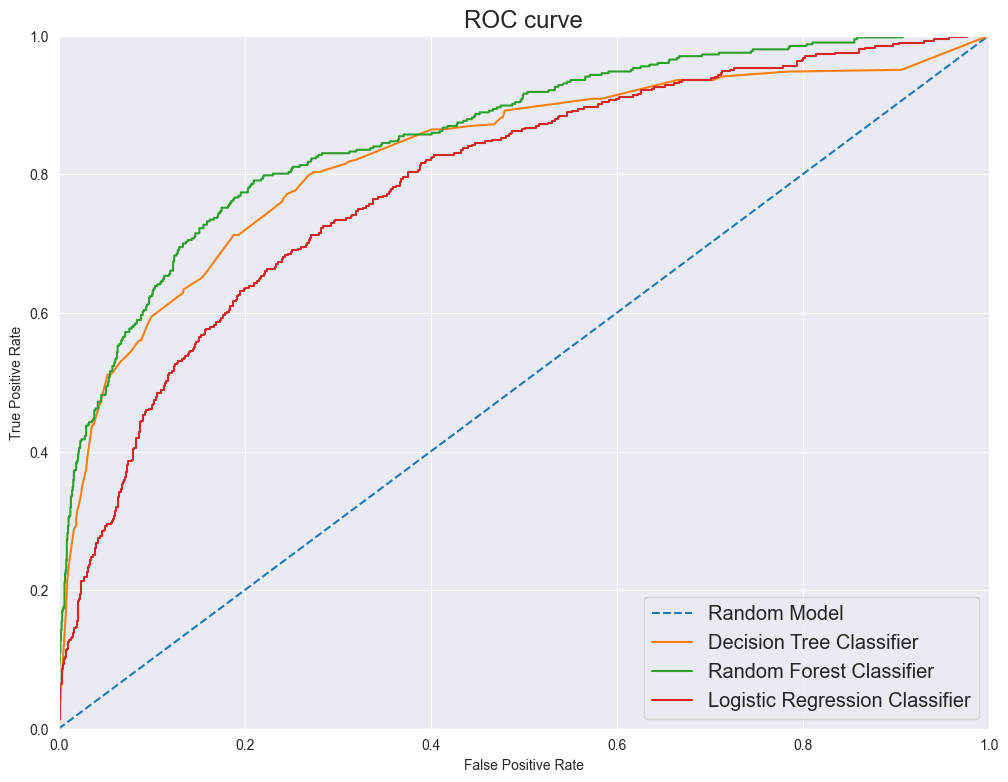

In [21]:
plt.figure(figsize=[12,9])
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model')

def roc(name, model, x_test, y_test):
    """ROC-curve fitting function"""
    probabilities_valid = model.predict_proba(x_test)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_valid)
    plt.plot(fpr, tpr, label= name)
    
roc('Decision Tree Classifier', best_model_DT, features_valid, target_valid)
roc('Random Forest Classifier', best_model_RF, features_valid, target_valid)
roc('Logistic Regression Classifier', best_model_LR, features_valid_scaled, target_valid)
    
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize='x-large')
plt.title("ROC curve", fontsize = 'xx-large')
plt.show()

<a id = 'data_preparation'></a>
<div style = 'border: solid green 4px; padding: 20px'>

<b>PRELIMINARY MODEL RESULTS (no class balancing)</b>

- Based on the baseline models (without handling class imbalance), the **Decision Tree** achieved the highest **F1 score**.
- The **Random Forest** achieved the best **ROC AUC**.

The target classes are imbalanced at approximately **1:4**.

This imbalance may affect model quality: across all baseline models, **recall is lower than precision**, which reduces the F1 score.

</div>


## Handling class imbalance



Next, we examine the confusion matrices for our baseline models.

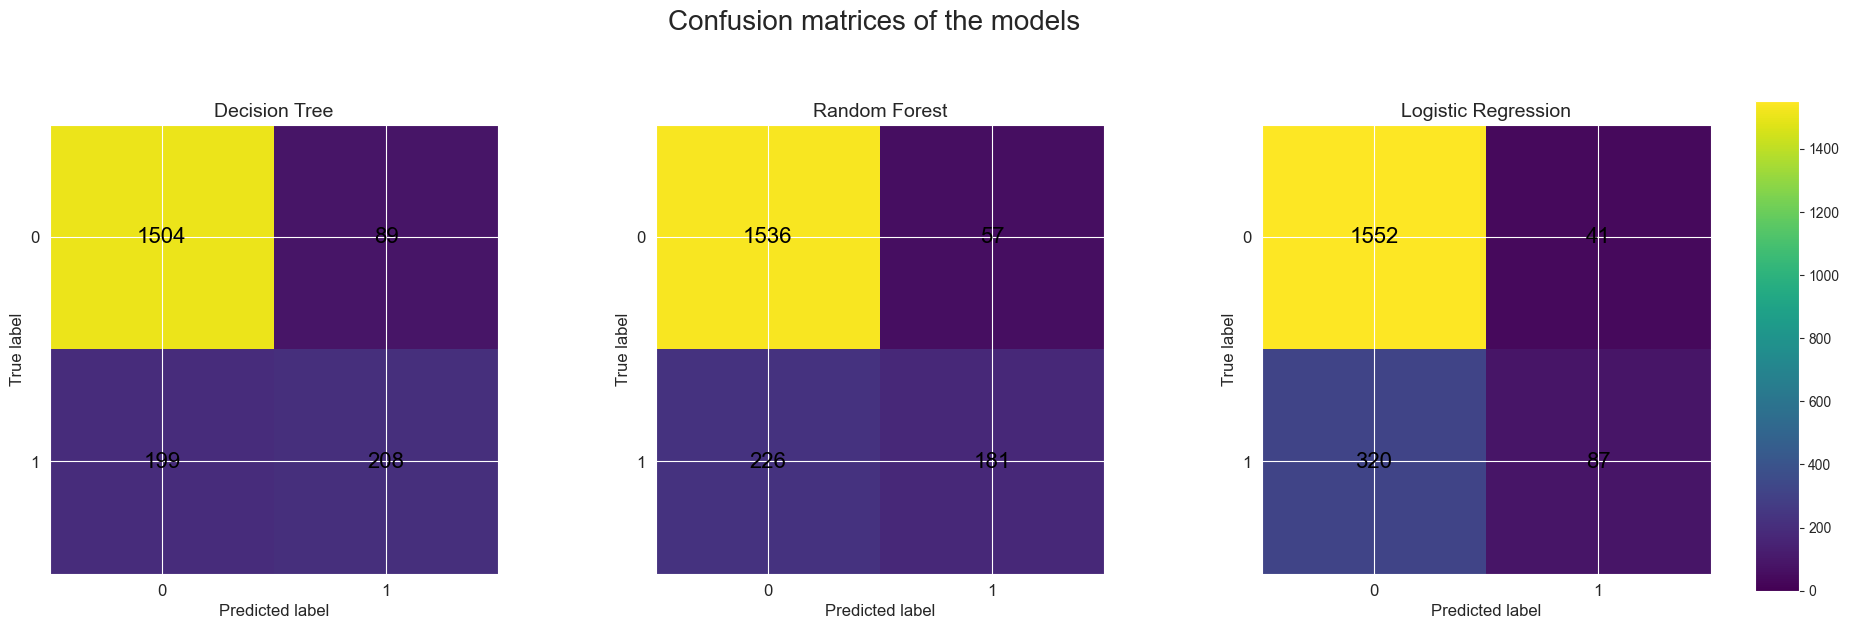

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(22, 7))
fig.suptitle('Confusion matrices of the models', fontsize=20)

fig.subplots_adjust(right=0.88, wspace=0.35) # Reserve space on the right for a shared colour bar

def plot_cm(model, X, y, axis, title):
    disp = ConfusionMatrixDisplay.from_estimator(model, X, y,ax=axis, colorbar=False, values_format='d')
    axis.set_title(title, fontsize=14)
    axis.set_xlabel('Predicted label', fontsize=12)
    axis.set_ylabel('True label', fontsize=12)
    axis.tick_params(axis='both', labelsize=12)
    if disp.text_ is not None:   # Make numbers black and bigger
        for t in disp.text_.ravel():
            t.set_color('black')
            t.set_fontsize(16)
    return disp

plot_cm(best_model_DT, features_valid, target_valid, ax[0], 'Decision Tree')
plot_cm(best_model_RF, features_valid, target_valid, ax[1], 'Random Forest')
plot_cm(best_model_LR, features_valid_scaled, target_valid, ax[2], 'Logistic Regression')

vmax = max(ax[i].images[0].get_array().max() for i in range(3)) # Use the same colour scale for all plots so colours are comparable
for i in range(3):
    ax[i].images[0].set_clim(0, vmax)

cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])  # Add a single shared colour bar on the right (outside the plots)
fig.colorbar(ax[0].images[0], cax=cax)
plt.show()


From the confusion matrices, we can see that most predictions fall into the **true negative** and **false negative** categories. This indicates a strong bias towards predicting class `0`, which is expected because class `0` is much more frequent than class `1`.

As a result, we should not expect good performance on the minority class with an imbalanced dataset. Therefore, we need to apply class-imbalance handling techniques in the next steps.

To address class imbalance, we will compare models using the following approaches:

- **Class weighting**
- **Undersampling** (reducing the majority class)
- **Oversampling** (increasing the minority class)


### Class weighting

In [23]:
print('Decision Tree Classifier balanced')
best_model_DT_balanced = DT_model(features_train, target_train, 'balanced')
dict_DT_balanced = metrics('Decision Tree Classifier balanced',best_model_DT_balanced, features_valid, target_valid)
print('\n')

print('Random Forest Classifier balanced')
best_model_RF_balanced = RF_model(features_train, target_train, 'balanced')
dict_RF_balanced = metrics('Random Forest Classifier balanced',best_model_RF_balanced, features_valid, target_valid)
print('\n')

print('Logistic Regression Classifier balanced')
best_model_LR_balanced = LR_model(features_train_scaled, target_train, 'balanced')
dict_LR_balanced = metrics('Logistic Regression Classifier balanced', best_model_LR_balanced, features_valid_scaled, target_valid)

Decision Tree Classifier balanced
Model parameters:
{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 12345,
 'splitter': 'best'}


,accuracy,recall,precision,f1_score,roc_auc
Decision Tree Classifier balanced,0.758,0.781327,0.446003,0.567857,0.821113




Random Forest Classifier balanced
Model parameters:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 60,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}


,accuracy,recall,precision,f1_score,roc_auc
Random Forest Classifier balanced,0.846,0.624079,0.621027,0.622549,0.864092




Logistic Regression Classifier balanced
Model parameters:
{'C': np.float64(0.1),
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 12345,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


,accuracy,recall,precision,f1_score,roc_auc
Logistic Regression Classifier balanced,0.717,0.724816,0.393858,0.510381,0.790893


In [24]:
dict_scores_balanced = {**dict_DT_balanced,**dict_RF_balanced, **dict_LR_balanced}
table_scores_balanced = pd.DataFrame(dict_scores_balanced).T
table_scores_balanced.columns = ['accuracy', 'recall', 'precision', 'f1_score', 'roc_auc']
pd.concat([table_scores, table_scores_balanced]).reset_index().sort_values(by = 'index')

,index,accuracy,recall,precision,f1_score,roc_auc
0,Decision Tree Classifier,0.8560,0.511057,0.700337,0.590909,0.827298
3,Decision Tree Classifier balanced,0.7580,0.781327,0.446003,0.567857,0.821113
2,Logistic Regression Classifier,0.8195,0.213759,0.679688,0.325234,0.787667
5,Logistic Regression Classifier balanced,0.7170,0.724816,0.393858,0.510381,0.790893
1,Random Forest Classifier,0.8585,0.444717,0.760504,0.561240,0.858090
4,Random Forest Classifier balanced,0.8460,0.624079,0.621027,0.622549,0.864092


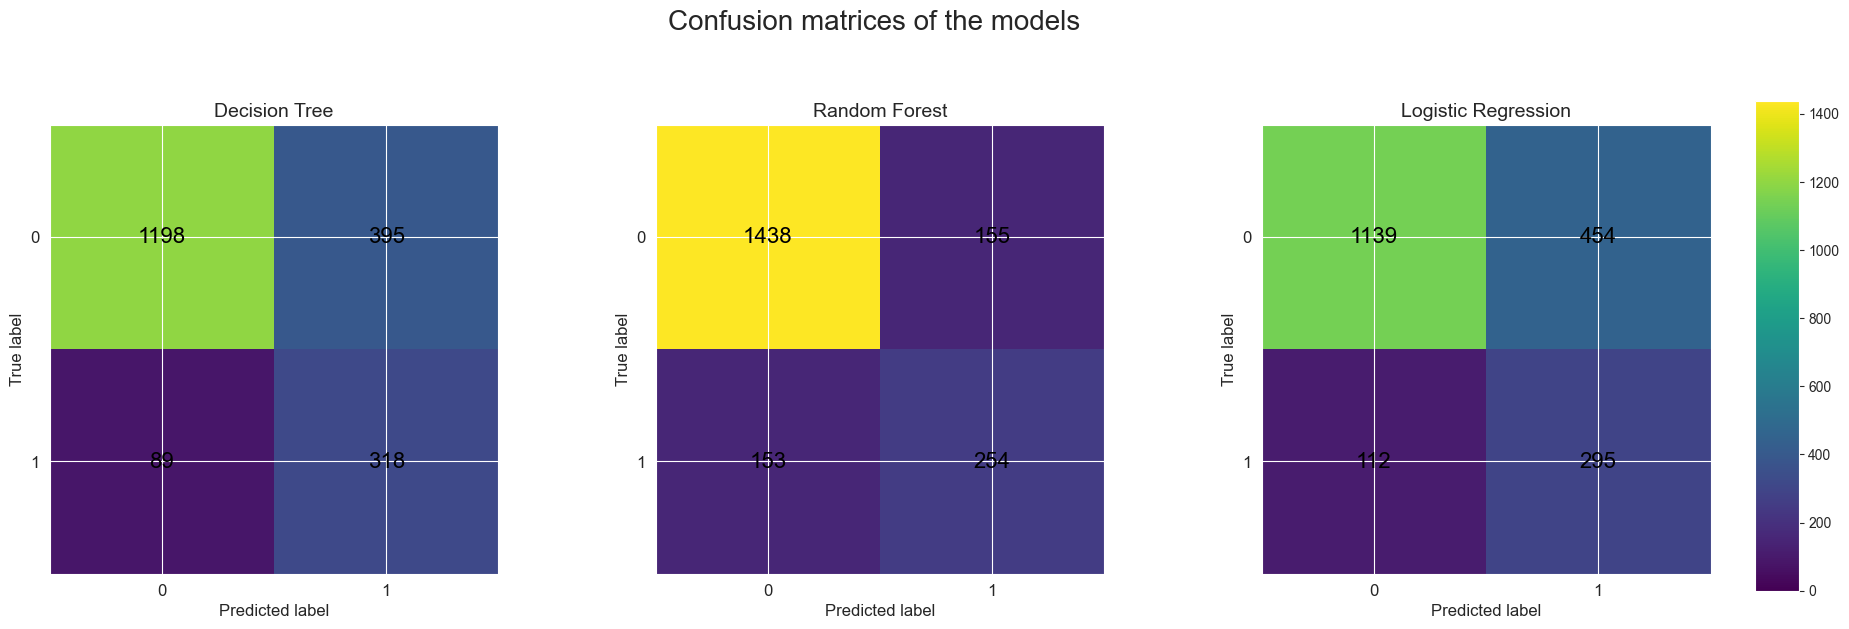

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(22, 7))
fig.suptitle('Confusion matrices of the models', fontsize=20)

fig.subplots_adjust(right=0.88, wspace=0.35) # Reserve space on the right for a shared colour bar

plot_cm(best_model_DT_balanced, features_valid, target_valid, ax[0], 'Decision Tree')
plot_cm(best_model_RF_balanced, features_valid, target_valid, ax[1], 'Random Forest')
plot_cm(best_model_LR_balanced, features_valid_scaled, target_valid, ax[2], 'Logistic Regression')

vmax = max(ax[i].images[0].get_array().max() for i in range(3)) # Use the same colour scale for all plots so colours are comparable
for i in range(3):
    ax[i].images[0].set_clim(0, vmax)

cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])  # Add a single shared colour bar on the right (outside the plots)
fig.colorbar(ax[0].images[0], cax=cax)
plt.show()


### Results with class weighting

- **Decision Tree:** the F1 score decreased, and the confusion matrix shifted towards more **false positives**.
- **Random Forest:** the F1 score increased substantially; the numbers of **false negatives** and **false positives** became closer.
- **Logistic Regression:** the F1 score increased noticeably, but this came at the cost of **lower accuracy**. The confusion matrix shifted towards more **false positives**.

The **ROC AUC** score changed only marginally (by less than 0.01).


### UnderSampling

We explore undersampling of the majority class (class `0`).

Here we apply **undersampling** to the training set: we randomly keep only 25% of the majority class (`0`) while keeping all samples from the minority class (`1`). Then we shuffle the resulting dataset. This reduces class imbalance and allows us to compare model performance under undersampling.



In [26]:
def undersample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_undersampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_undersampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_undersampled, target_undersampled = shuffle(features_undersampled, target_undersampled, random_state=12345)
    
    return features_undersampled, target_undersampled

features_undersampled, target_undersampled = undersample(features_train, target_train, 0.25)
print(target_undersampled.value_counts())

exited
1    1223
0    1194
Name: count, dtype: int64


In [27]:
%%time
print('Decision Tree Classifier undersample')
best_model_DT_us = DT_model(features_undersampled, target_undersampled, None)
dict_DT_us = metrics('Decision Tree Classifier undersample', best_model_DT_us, features_valid, target_valid)
print('\n')

print('Random Forest Classifier undersample')
best_model_RF_us = RF_model(features_undersampled, target_undersampled, None)
dict_RF_us = metrics('Random Forest Classifier undersample', best_model_RF_us, features_valid, target_valid)
print('\n')


print('Logistic Regression Classifier undersample')
best_model_LR_us = LR_model(scaler(features_undersampled), target_undersampled, None)
dict_LR_us = metrics('Logistic Regression Classifier undersample', best_model_LR_us, scaler(features_valid), target_valid)


Decision Tree Classifier undersample
Model parameters:
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 12345,
 'splitter': 'best'}


,accuracy,recall,precision,f1_score,roc_auc
Decision Tree Classifier undersample,0.7285,0.823096,0.415633,0.55235,0.844566




Random Forest Classifier undersample
Model parameters:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 120,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}


,accuracy,recall,precision,f1_score,roc_auc
Random Forest Classifier undersample,0.7885,0.771499,0.487578,0.597526,0.869759




Logistic Regression Classifier undersample
Model parameters:
{'C': np.float64(0.1),
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 12345,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


,accuracy,recall,precision,f1_score,roc_auc
Logistic Regression Classifier undersample,0.7115,0.739558,0.389896,0.510602,0.786242


CPU times: total: 2min 46s
Wall time: 2min 47s


In [28]:
dict_scores_us = {**dict_DT_us,**dict_RF_us, **dict_LR_us}
table_scores_us = pd.DataFrame(dict_scores_us).T
table_scores_us.columns = ['accuracy', 'recall', 'precision', 'f1_score', 'roc_auc']
pd.concat([table_scores, table_scores_balanced, table_scores_us]).reset_index().sort_values(by = 'index').set_index('index')

,accuracy,recall,precision,f1_score,roc_auc
index,,,,,
Decision Tree Classifier,0.8560,0.511057,0.700337,0.590909,0.827298
Decision Tree Classifier balanced,0.7580,0.781327,0.446003,0.567857,0.821113
Decision Tree Classifier undersample,0.7285,0.823096,0.415633,0.552350,0.844566
Logistic Regression Classifier,0.8195,0.213759,0.679688,0.325234,0.787667
Logistic Regression Classifier balanced,0.7170,0.724816,0.393858,0.510381,0.790893
Logistic Regression Classifier undersample,0.7115,0.739558,0.389896,0.510602,0.786242
Random Forest Classifier,0.8585,0.444717,0.760504,0.561240,0.858090
Random Forest Classifier balanced,0.8460,0.624079,0.621027,0.622549,0.864092
Random Forest Classifier undersample,0.7885,0.771499,0.487578,0.597526,0.869759


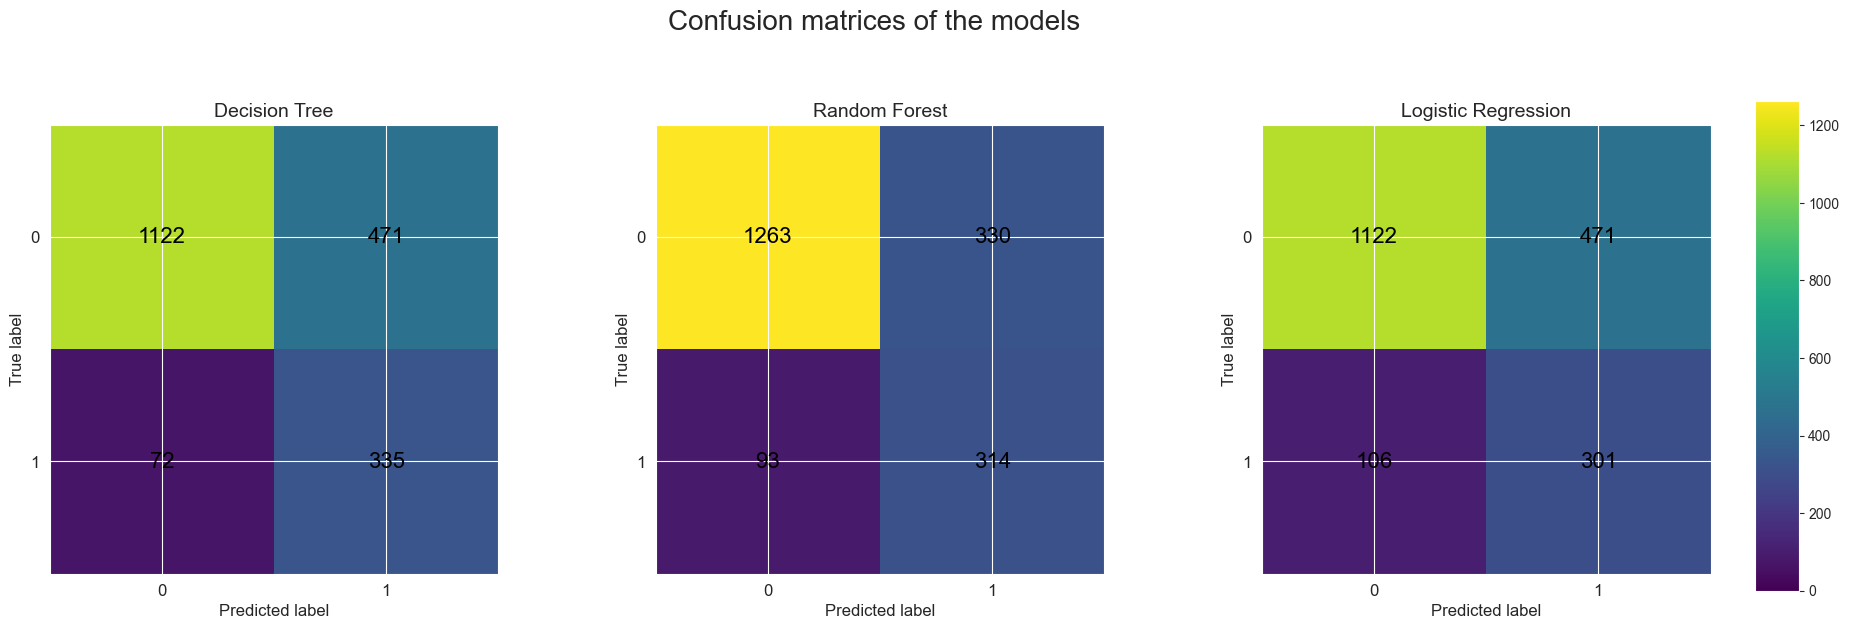

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(22, 7))
fig.suptitle('Confusion matrices of the models', fontsize=20)

fig.subplots_adjust(right=0.88, wspace=0.35) # Reserve space on the right for a shared colour bar

plot_cm(best_model_DT_us, features_valid, target_valid, ax[0], 'Decision Tree')
plot_cm(best_model_RF_us, features_valid, target_valid, ax[1], 'Random Forest')
plot_cm(best_model_LR_us, features_valid_scaled, target_valid, ax[2], 'Logistic Regression')

vmax = max(ax[i].images[0].get_array().max() for i in range(3)) # Use the same colour scale for all plots so colours are comparable
for i in range(3):
    ax[i].images[0].set_clim(0, vmax)

cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])  # Add a single shared colour bar on the right (outside the plots)
fig.colorbar(ax[0].images[0], cax=cax)
plt.show()

With undersampling, all models shift towards predicting the positive class more often (more positive predictions overall).

Among the approaches tested so far, **class weighting** provides a larger improvement in **F1 score** for the **Random Forest** model.


### OverSampling

We explore **oversampling** of the minority class (class `1`) in the training set.

In this function, we increase the number of minority-class samples by **repeating** the rows where `target == 1` (`repeat` times), while keeping all majority-class samples (`target == 0`) unchanged. We then shuffle the resulting dataset to mix the classes.

Here we set `repeat = 4`, so class `1` is replicated four times, which reduces class imbalance. Finally, we print the new class counts to confirm the updated distribution.


In [30]:
def oversample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_oversampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_oversampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_oversampled, target_oversampled = shuffle(features_oversampled, target_oversampled, random_state=12345)
    
    return features_oversampled, target_oversampled

features_oversampled, target_oversampled = oversample(features_train, target_train, 4)

print(target_oversampled.value_counts())

exited
1    4892
0    4777
Name: count, dtype: int64


In [32]:
%%time
print('Decision Tree Classifier oversample')
best_model_DT_os = DT_model(features_oversampled, target_oversampled, None)
dict_DT_os = metrics('Decision Tree Classifier oversample',best_model_DT_os, features_valid, target_valid)
print('\n')

print('Random Forest Classifier oversample')
best_model_RF_os = RF_model(features_oversampled, target_oversampled, None)
dict_RF_os = metrics('Random Forest Classifier oversample',best_model_RF_os, features_valid, target_valid)
print('\n')


print('Logistic Regression Classifier oversample')
best_model_LR_os = LR_model(scaler(features_oversampled), target_oversampled, None)
dict_LR_os = metrics('Logistic Regression Classifier oversample', best_model_LR_os, scaler(features_valid), target_valid)


Decision Tree Classifier oversample
Model parameters:
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 12345,
 'splitter': 'best'}


,accuracy,recall,precision,f1_score,roc_auc
Decision Tree Classifier oversample,0.7655,0.702703,0.451104,0.549472,0.770243




Random Forest Classifier oversample
Model parameters:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}


,accuracy,recall,precision,f1_score,roc_auc
Random Forest Classifier oversample,0.8425,0.547912,0.629944,0.586071,0.84969




Logistic Regression Classifier oversample
Model parameters:
{'C': np.float64(0.1),
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 12345,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


,accuracy,recall,precision,f1_score,roc_auc
Logistic Regression Classifier oversample,0.7095,0.739558,0.387887,0.508876,0.79107


CPU times: total: 8min
Wall time: 8min 1s


In [40]:
dict_scores_os = {**dict_DT_os,**dict_RF_os, **dict_LR_os}
table_scores_os = pd.DataFrame(dict_scores_os).T
table_scores_os.columns = ['accuracy', 'recall', 'precision', 'f1_score', 'roc_auc']
pd.concat([table_scores, table_scores_balanced, table_scores_us, table_scores_os]).reset_index().sort_values(by = 'index').set_index('index')

,accuracy,recall,precision,f1_score,roc_auc
index,,,,,
Decision Tree Classifier,0.8560,0.511057,0.700337,0.590909,0.827298
Decision Tree Classifier balanced,0.7580,0.781327,0.446003,0.567857,0.821113
Decision Tree Classifier oversample,0.7655,0.702703,0.451104,0.549472,0.770243
Decision Tree Classifier undersample,0.7285,0.823096,0.415633,0.552350,0.844566
Logistic Regression Classifier,0.8195,0.213759,0.679688,0.325234,0.787667
Logistic Regression Classifier balanced,0.7170,0.724816,0.393858,0.510381,0.790893
Logistic Regression Classifier oversample,0.7095,0.739558,0.387887,0.508876,0.791070
Logistic Regression Classifier undersample,0.7115,0.739558,0.389896,0.510602,0.786242
Random Forest Classifier,0.8585,0.444717,0.760504,0.561240,0.858090


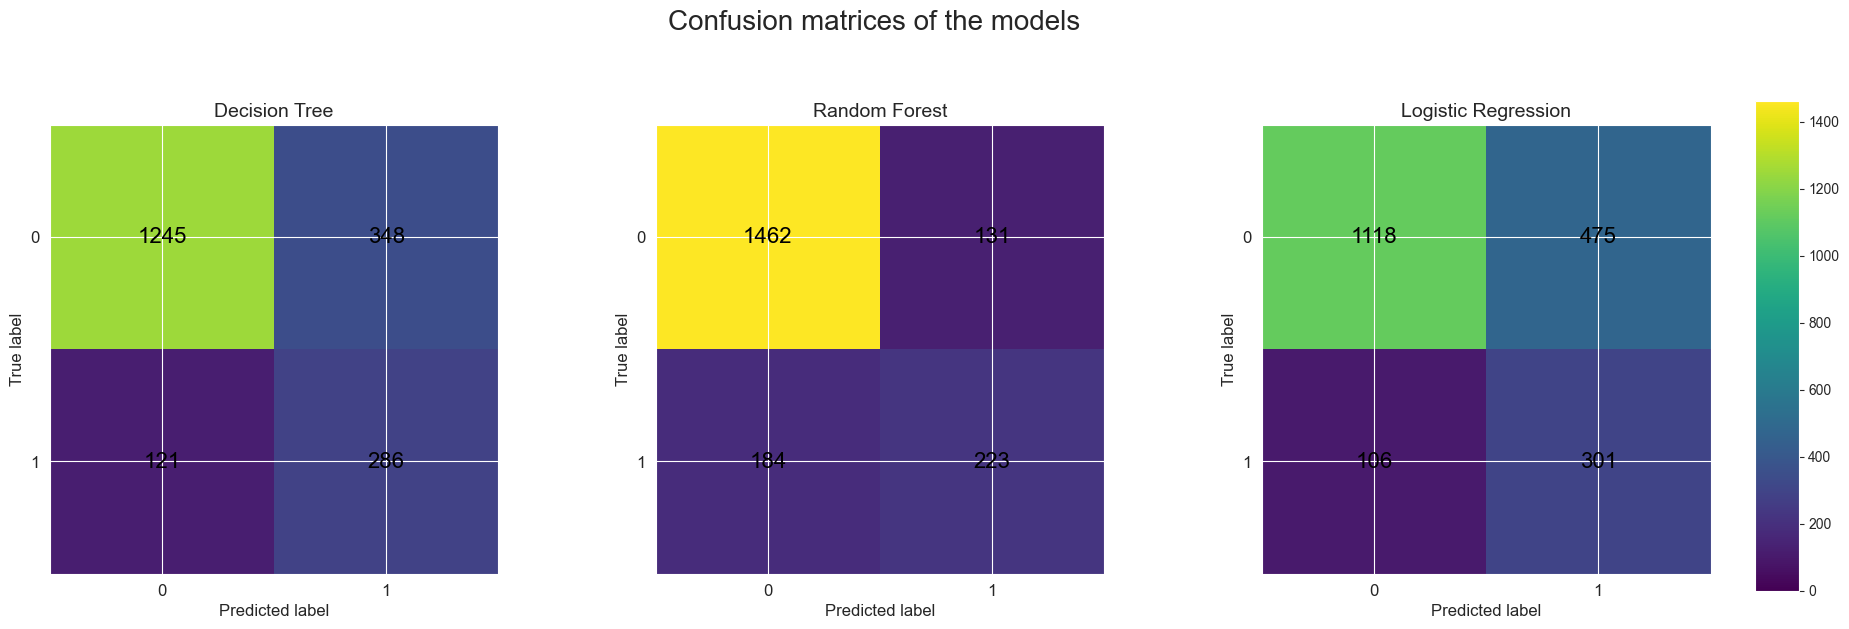

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(22, 7))
fig.suptitle('Confusion matrices of the models', fontsize=20)

fig.subplots_adjust(right=0.88, wspace=0.35)  # Reserve space on the right for a shared colour bar

plot_cm(best_model_DT_os, features_valid, target_valid, ax[0], 'Decision Tree')
plot_cm(best_model_RF_os, features_valid, target_valid, ax[1], 'Random Forest')
plot_cm(best_model_LR_os, features_valid_scaled, target_valid, ax[2], 'Logistic Regression')

vmax = max(ax[i].images[0].get_array().max() for i in
           range(3))  # Use the same colour scale for all plots so colours are comparable
for i in range(3):
    ax[i].images[0].set_clim(0, vmax)

cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])  # Add a single shared colour bar on the right (outside the plots)
fig.colorbar(ax[0].images[0], cax=cax)
plt.show()

Similarly to the previous class-imbalance approaches, we observe the following:

- a strong increase in the F1 score for **Logistic Regression**, but the improvement is larger with **class weighting**;
- an increase in the F1 score for **Random Forest**, but the improvement is larger with **class weighting**;
- a decrease in the F1 score for **Decision Tree**, and the drop is stronger than in the previous approaches.


The highest F1 score was achieved by the **Random Forest** model.

Among the tested imbalance-handling approaches, **class weighting** produced the best overall results.


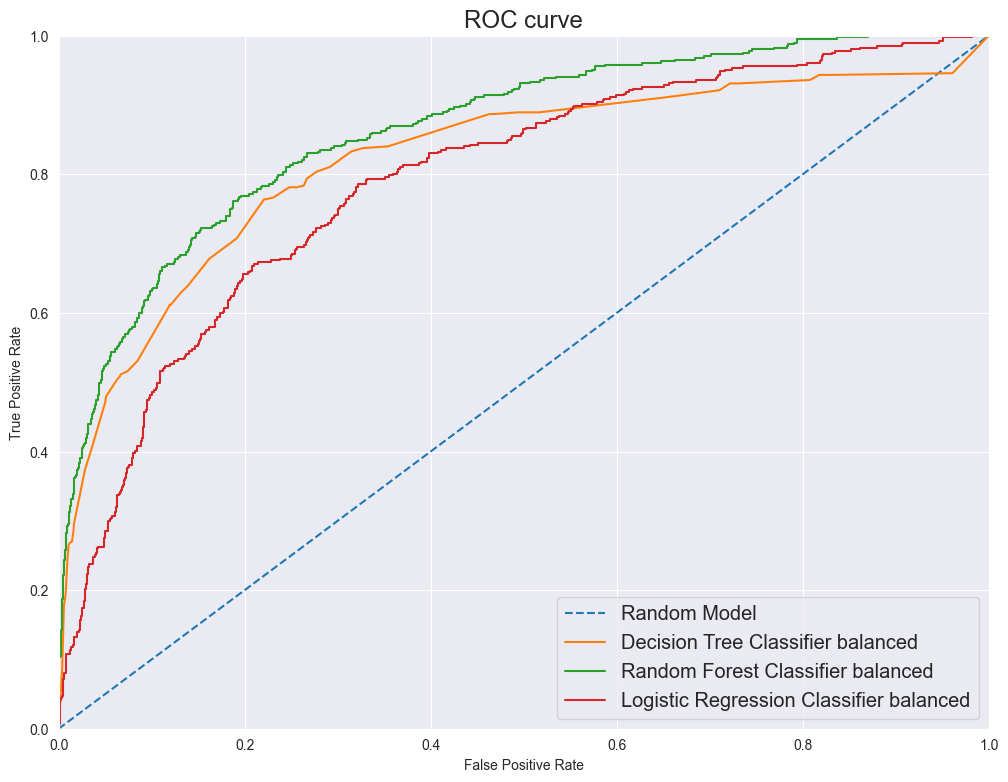

In [35]:
plt.figure(figsize=[12,9])
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model')

roc('Decision Tree Classifier balanced', best_model_DT_balanced, features_valid, target_valid)
roc('Random Forest Classifier balanced', best_model_RF_balanced, features_valid, target_valid)
roc('Logistic Regression Classifier balanced', best_model_LR_balanced, features_valid_scaled, target_valid)
    
    
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize='x-large')
plt.title("ROC curve", fontsize = 'xx-large')
plt.show()

### Choosing an imbalance-handling approach

Across the tested approaches (class weighting, undersampling, and oversampling), the best results in this project were achieved using **class weighting**. This approach produced the highest **F1 score** for the **Random Forest** model and provided a good trade-off between precision and recall.



## Final testing

After selecting the final model and hyperparameters based on the validation set, we retrain the model on the combined training + validation data to make use of more labelled examples before evaluating on the test set.


In [36]:
features_train = pd.concat([features_train, features_valid], axis=0)# increase the training set by adding the validation set
target_train   = pd.concat([target_train,   target_valid], axis=0)

Random Forest Classifier balanced
Model parameters:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}


,accuracy,recall,precision,f1_score,roc_auc
Random Forest Classifier balanced,0.855,0.648649,0.642336,0.645477,0.867513


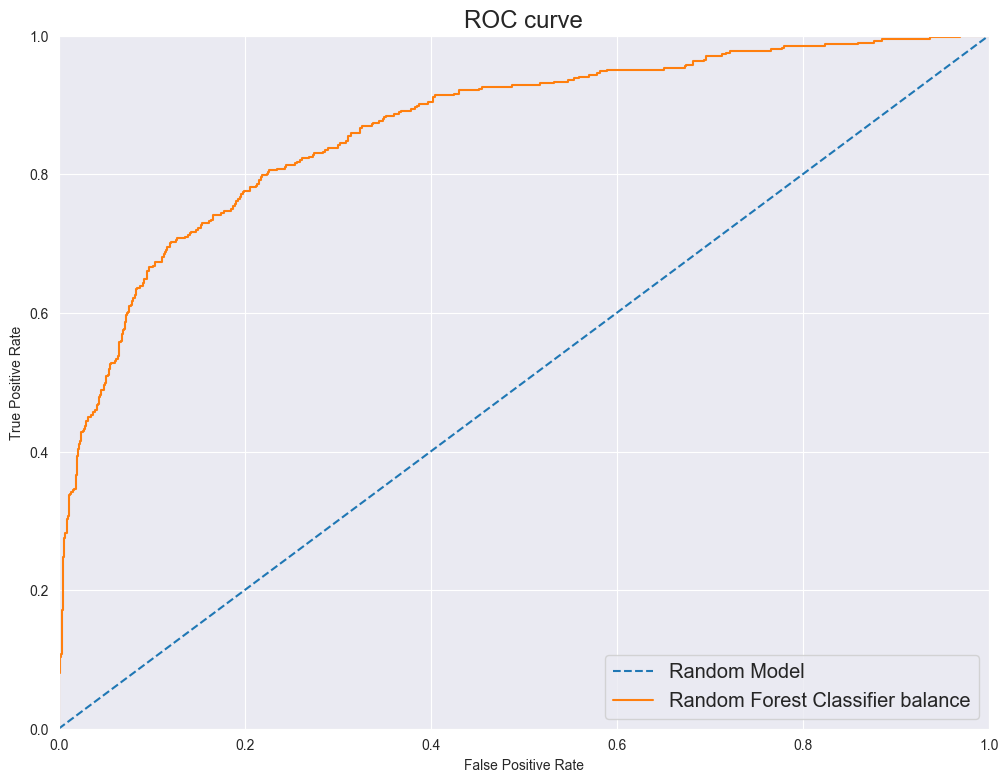

In [37]:
print('Random Forest Classifier balanced')
best_model_RF_balanced = RF_model(features_train, target_train, 'balanced')
metrics('Random Forest Classifier balanced', best_model_RF_balanced, features_test, target_test)

plt.figure(figsize=[12,9])
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model')

roc('Random Forest Classifier balance', best_model_RF_balanced, features_test, target_test)

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize='x-large')
plt.title("ROC curve", fontsize = 'xx-large')
plt.show()

We will compare our model against a naive baseline that predicts a constant target value of `0` (the most frequent class).

In [38]:
model_dmb = DummyClassifier(strategy='most_frequent', random_state=12345, constant = 0)
model_dmb.fit(features_train, target_train)
print('Random model')
dict_dmb = metrics('Random Model', model_dmb, features_test, target_test)

Random model
Model parameters:
{'constant': 0, 'random_state': 12345, 'strategy': 'most_frequent'}


,accuracy,recall,precision,f1_score,roc_auc
Random Model,0.7965,0.0,0.0,0.0,0.5


Feature importance in Random Forest Model


,features,importance
1,age,0.296437
3,num_of_products,0.178120
2,balance,0.144910
6,estimated_salary,0.121983
0,credit_score,0.117656
5,is_active_member,0.052390
7,geography_Germany,0.036564
9,gender_Male,0.024291
4,has_cr_card,0.014316
8,geography_Spain,0.013334


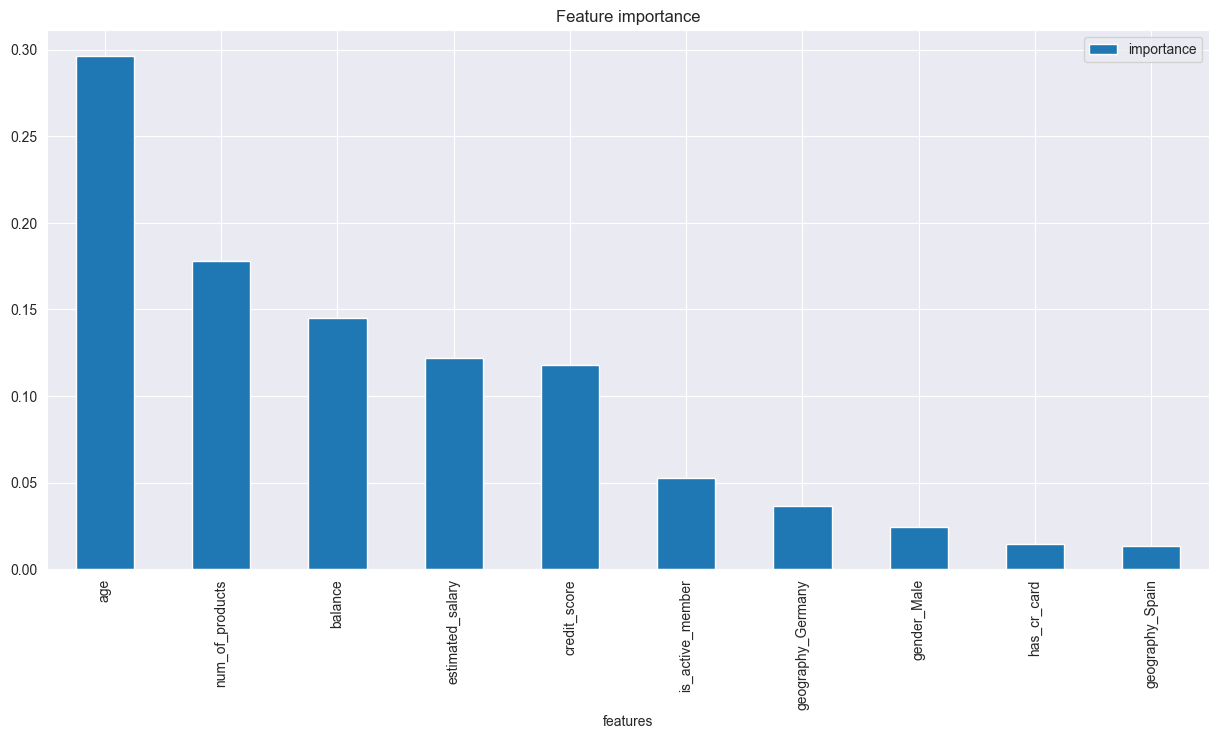

In [39]:
feats_RF = {feature:importance for feature, importance in zip(features.columns, best_model_RF_balanced.feature_importances_)}
importances_RF = pd.DataFrame(feats_RF.items(), columns = ['features', 'importance'])
print('Feature importance in Random Forest Model')
importances_RF.sort_values(by='importance', ascending = False).plot(kind = 'bar', x = 'features', title = 'Feature importance', xlabel = 'features', figsize = (15,7))
importances_RF.sort_values(by='importance', ascending = False)

From the feature-importance bar plot, we can see that our initial observations from the exploratory analysis were confirmed. The most influential feature is the customer’s **age**, followed by the **number of bank products** the customer uses.


<a id = 'data_preparation'></a>
<div style = 'border: solid green 6px; padding: 20px'>
    
### Summary

- We explored the dataset, performed data preprocessing, and carried out exploratory data analysis (EDA).
- The data was split into training, validation, and test sets.
- We confirmed that the target classes are imbalanced.
- We trained baseline models without class balancing.
- Hyperparameters were tuned using **GridSearchCV**.
- The main evaluation metric in this project is the **F1 score**.
- To address class imbalance, we tested three approaches. The best results were achieved using **class weighting** with the **Random Forest** model.
- Final testing was performed:
  - **Model:** Random Forest
  - **Parameters:**
    `{'bootstrap': True,
      'ccp_alpha': 0.0,
      'class_weight': 'balanced',
      'criterion': 'gini',
      'max_depth': None,
      'max_features': 'sqrt',
      'max_leaf_nodes': None,
      'max_samples': None,
      'min_impurity_decrease': 0.0,
      'min_samples_leaf': 4,
      'min_samples_split': 2,
      'min_weight_fraction_leaf': 0.0,
      'n_estimators': 100,
      'n_jobs': None,
      'oob_score': False,
      'random_state': 12345,
      'verbose': 0,
      'warm_start': False}`
  - **Test metrics:**
    - accuracy = 0.855
    - recall = 0.648649
    - precision = 0.642336
    - **f1_score = 0.645477**
    - roc_auc = 0.867513
  - We sanity-checked the model by comparing it with a constant baseline that predicts class `0`.
  - We analysed feature importance.

    
